In [1]:
import pandas as pd
import numpy as np
import scipy.interpolate
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt

import wrds
 
from mylib.load_from_wrds import query_options, query_stock, query_dividend, query_zero_curve
from mylib.rates_tools import create_yield_curve, merge_interest

%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
db = wrds.Connection(wrds_username = config['WRDS_USER'])

Loading library list...
Done


In [3]:
secid = 113993
spec_date = '2021-01-11'

df_option = query_options(db, secid, startdate = spec_date, enddate = spec_date)
df_option = df_option.loc[df_option['date'] == spec_date, :]

df_stock = query_stock(db, secid, startdate = spec_date, enddate = spec_date)

In [17]:
df = df_option.merge(df_stock[['date', 'close']], how = 'left', on = 'date')

df.loc[df['cp_flag'] == 'C', 'POP'] = df['V0'] - np.max(df['close'] - df['K'], 0) 
df.loc[df['cp_flag'] == 'P', 'POP'] = df['V0'] - np.max(df['K'] - df['close'], 0)  

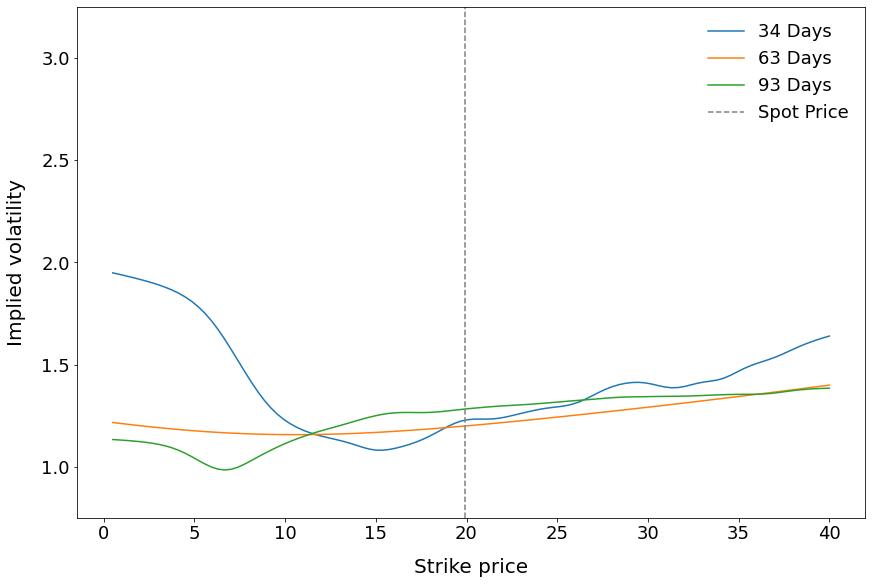

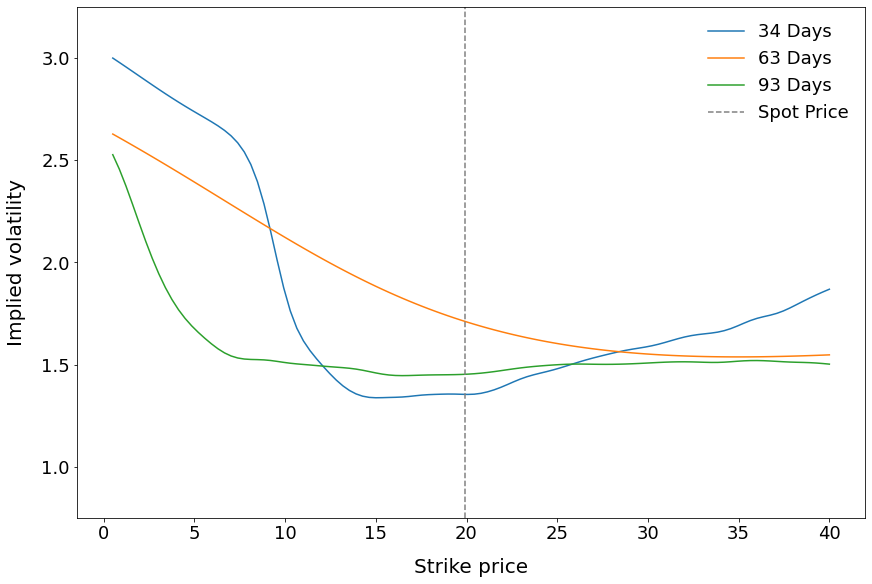

In [18]:
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

date = spec_date
for cpflag in ['C', 'P']:
    row = df.loc[(df['date'] == date) & (df['cp_flag'] == cpflag), ['date', 'K', 'close', 'V0', 'tau_days', 'impl_volatility']]
    xi = np.linspace(min(row.tau_days), max(row.tau_days), 100)    
    yi = np.linspace(min(row.K), max(row.K), 110)
    X, Y = np.meshgrid(xi, yi)
    row = row.dropna()
    close = np.unique(row.close)

    spline = scipy.interpolate.Rbf(row.tau_days, row.K, row.impl_volatility, function='linear')
    Z = spline(X,Y)

    # Volatility Skew
    maturitylist = np.unique(X)
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    ax = fig.add_subplot(111)
    idx = np.argmin(np.abs(np.array(maturitylist)-30))
    plt.plot(Y[:,idx], Z[:,idx], label = str(round(maturitylist[idx])) + ' Days')
    idx = np.argmin(np.abs(np.array(maturitylist)-60))
    plt.plot(Y[:,idx], Z[:,idx], label = str(round(maturitylist[idx])) + ' Days')
    idx = np.argmin(np.abs(np.array(maturitylist)-90))
    plt.plot(Y[:,idx], Z[:,idx], label =  str(round(maturitylist[idx])) + ' Days')
    plt.axvline(x = close, color = 'grey', linestyle = '--', label = 'Spot Price')
    ax.set_xlabel('Strike price', labelpad=15)
    ax.set_ylabel('Implied volatility', labelpad=15)
    ax.set_ylim([0.75, 3.25]) 

    plt.legend(frameon=False)
    # plt.savefig(output_path + str(securityid) + '/' + str(securityid) + '_vol_skew' + '_' + date + '_' + cpflag + '.jpg', dpi=300, bbox_inches='tight')
    # plt.close()

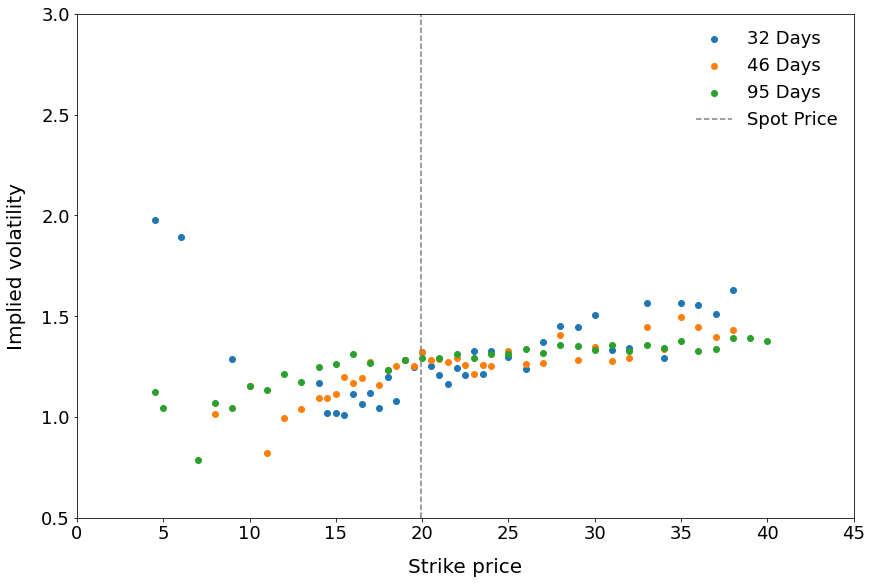

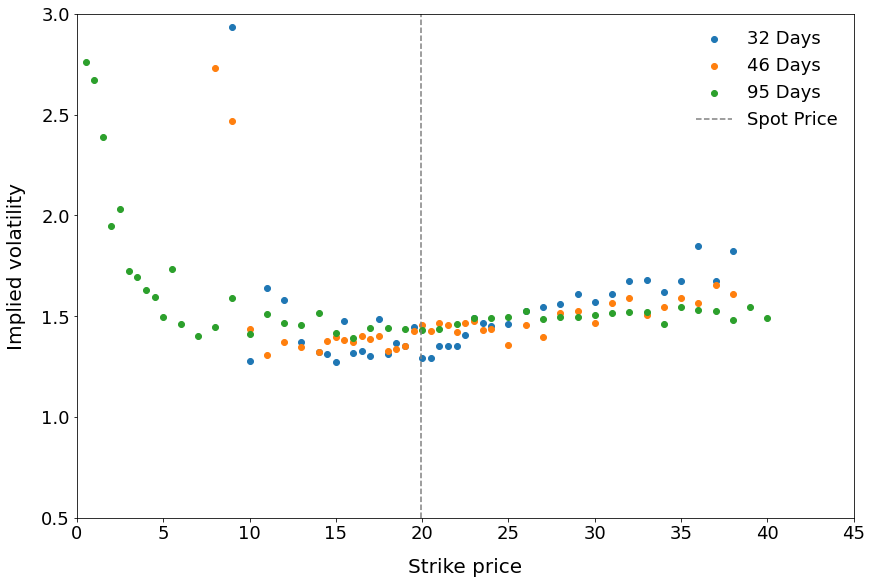

In [19]:
date = spec_date
for cpflag in ['C', 'P']:
    row = df.loc[(df['date'] == date) & (df['cp_flag'] == cpflag), ['date', 'K', 'close', 'V0', 'tau_days', 'impl_volatility']]
        
    # Volatility Skew
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    plt.scatter(row.loc[row['tau_days'] == 32, 'K'].values, row.loc[row['tau_days'] == 32, 'impl_volatility'].values, label = '32 Days')
    plt.scatter(row.loc[row['tau_days'] == 46, 'K'].values, row.loc[row['tau_days'] == 46, 'impl_volatility'].values, label = '46 Days')
    plt.scatter(row.loc[row['tau_days'] == 95, 'K'].values, row.loc[row['tau_days'] == 95, 'impl_volatility'].values, label = '95 Days')
    
    plt.axvline(x = close, color = 'grey', linestyle = '--', label = 'Spot Price')
    ax.set_xlabel('Strike price', labelpad=15)
    ax.set_ylabel('Implied volatility', labelpad=15)
    ax.set_xlim([0, 45]) 
    ax.set_ylim([0.5, 3.0]) 

    plt.legend(frameon=False)
    # plt.savefig(output_path + str(securityid) + '/' + str(securityid) + '_vol_skew' + '_' + date + '_' + cpflag + '.jpg', dpi=300, bbox_inches='tight')
    # plt.close()

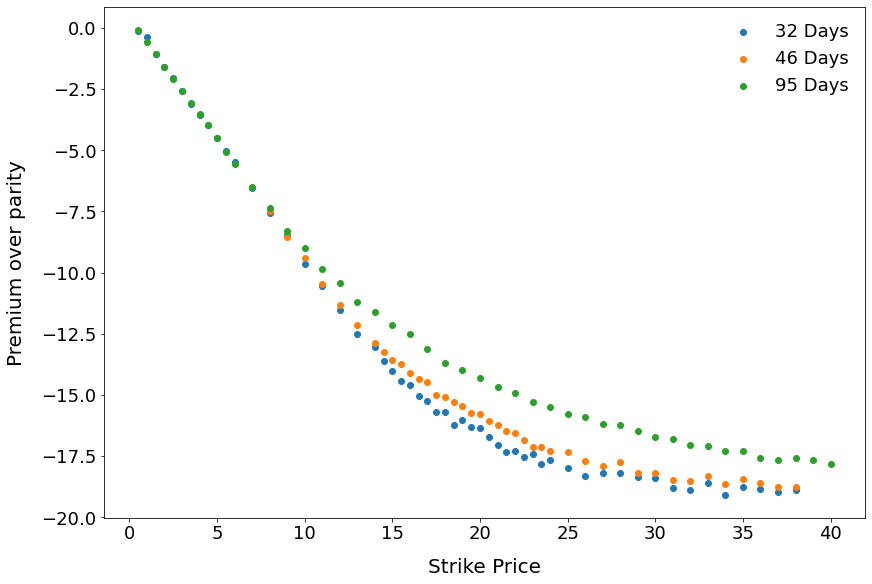

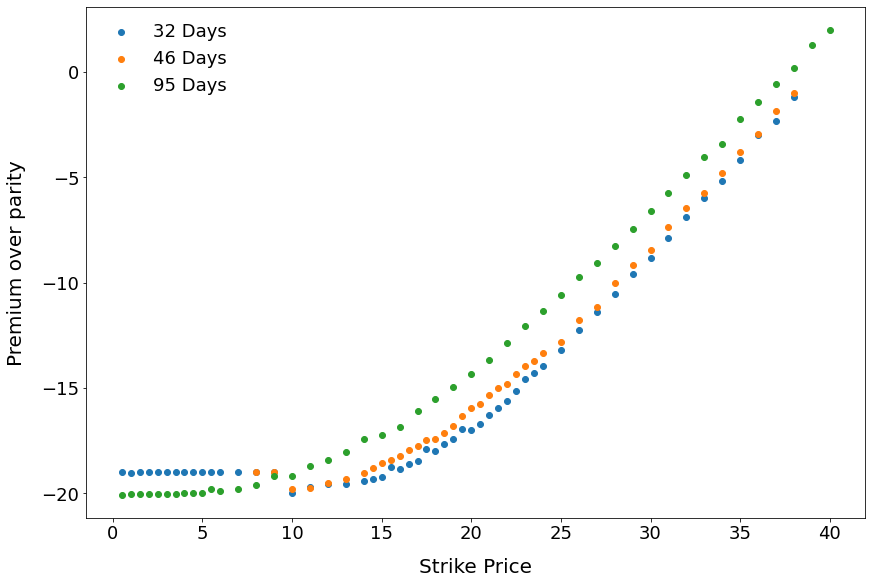

In [20]:
date = spec_date
for cpflag in ['C', 'P']:
    row = df.loc[(df['date'] == date) & (df['cp_flag'] == cpflag), ['date', 'K', 'close', 'V0', 'tau_days', 'impl_volatility', 'POP']]
        
    # Volatility Skew
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    ax = fig.add_subplot(111)
    
    plt.scatter(row.loc[row['tau_days'] == 32, 'K'].values, row.loc[row['tau_days'] == 32, 'POP'].values, label = '32 Days')
    plt.scatter(row.loc[row['tau_days'] == 46, 'K'].values, row.loc[row['tau_days'] == 46, 'POP'].values, label = '46 Days')
    plt.scatter(row.loc[row['tau_days'] == 95, 'K'].values, row.loc[row['tau_days'] == 95, 'POP'].values, label = '95 Days')
    
    ax.set_xlabel('Strike Price', labelpad=15)
    ax.set_ylabel('Premium over parity', labelpad=15)
    # ax.set_ylim([0.5, 3.0]) 

    plt.legend(frameon=False)
    # plt.savefig(output_path + str(securityid) + '/' + str(securityid) + '_vol_skew' + '_' + date + '_' + cpflag + '.jpg', dpi=300, bbox_inches='tight')
    # plt.close()